In [1]:
# we import the libraris to run to code

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LinearRegression1
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Next we are reading the files and see what contains

df = pd.read_csv('Housing.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7229300521,20141013T000000,231300.0,2,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
def text2date(text):
    return datetime.datetime.strptime(text[:8], "%Y%m%d")

df2 = df.copy()

df2['date'] = df2['date'].apply(text2date)


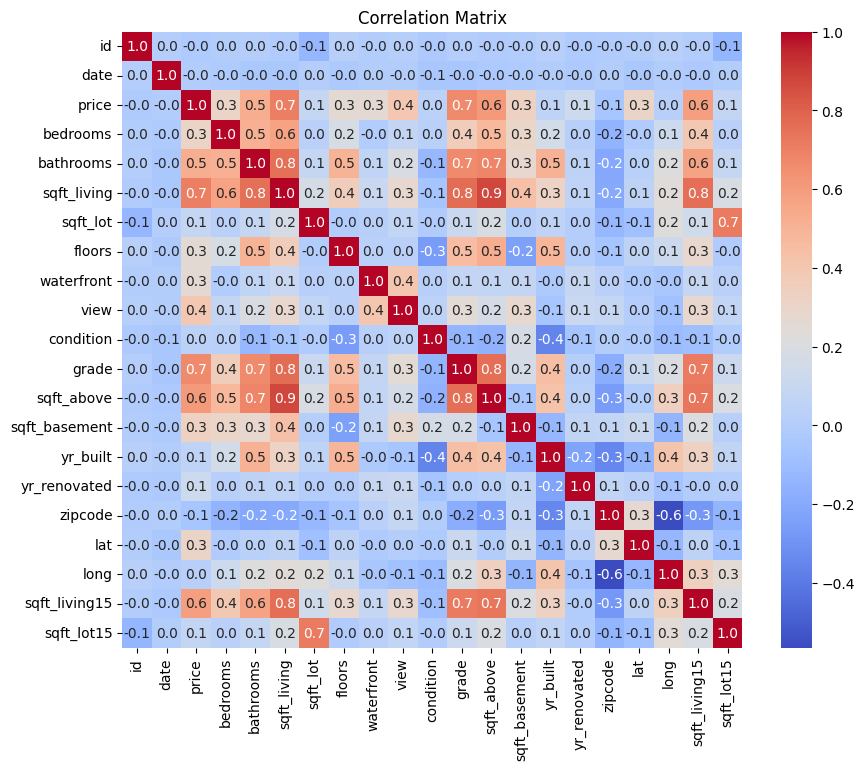

In [4]:
corr_matrix = df2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Matrix')
plt.show()

In [5]:
df_model = df2[['bedrooms','bathrooms','sqft_living','view','grade', 'sqft_above', 'sqft_living15', 'price']]

# Gonna split our dimensions to train vs the price
dimensions = df_model[['bedrooms', 'bathrooms', 'sqft_living', 'view', 'grade', 'sqft_above', 'sqft_living15']]  # Features
Price = df2['price']

X_train, X_test, y_train, y_test = train_test_split(dimensions, Price, test_size=0.2, random_state=100)

model = LinearRegression1()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

diff_any = (y_test - y_pred)/y_pred

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE): ", round(mse, 3))

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE): ", round(rmse, 3))

print("The average diference is: ", round(np.average(diff_any), 3))

r2 = r2_score(y_test, y_pred)
print("R-squared: ", round(r2, 3))

Mean Squared Error (MSE):  54419423844.994
Root Mean Squared Error (RMSE):  233279.712
The average diference is:  0.021
R-squared:  0.596


In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dense

In [7]:
spark = SparkSession.builder.appName("LSTM Model").getOrCreate()

df_spark = spark.read.csv("Housing.csv", header=True, inferSchema=True)

features = ['bedrooms', 'bathrooms', 'sqft_living', 'view', 'grade', 'sqft_above', 'sqft_living15']
target = 'price'

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_spark = assembler.transform(df_spark)

train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=100)
train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()

model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(train_data_pd.shape[1], len(features))))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

X_train = train_data_pd[features].values.reshape((train_data_pd.shape[0], 1, len(features)))
y_train = train_data_pd[target].values

model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
X_test = test_data_pd[features].values.reshape((test_data_pd.shape[0], 1, len(features)))
predictions = model.predict(X_test)

mse = ((test_data_pd[target] - predictions.flatten()) ** 2).mean()
print("Mean Squared Error:", mse)

RMSE = np.sqrt(mse)

print("Root Mean Squared Error:", RMSE)

r2 = r2_score(test_data_pd[target], predictions.flatten())
print("R-squared Error:", r2)

spark.stop()

Epoch 1/100


c:\Users\pauca\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 424340488192.0000
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 402314002432.0000
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 384150798336.0000
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 331701190656.0000
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 291385475072.0000
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 244773634048.0000
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 208193929216.0000
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 166548324352.0000
Epoch 9/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136562343936.0000
Epoch 10/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 109480067072.0000
Epoch 11/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97352859648.0000
Epoch 12/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 81662574592.0000
Epoch 13/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -